In [ ]:
import os
import multiprocessing
from functools import partial

import faiss
import numpy as np
import torch

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.res = faiss.StandardGpuResources()

        self.gpu_index = faiss.index_cpu_to_gpu(
            self.res,
            0,
            self.index
        )
        self.y = y

    def predict(self, X):
        distances, indices = self.gpu_index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return indices, distances

In [3]:
# basic params

k = 2
n = 2
N = 1000000
num_neg = 500000
num_pos = N - num_neg
r = 1.0
max_norm = 0.1

k_neighbors = 50

# making the sphere

points_k = np.random.normal(0, 1, size=(num_pos, k))
points_k = r * (points_k / np.linalg.norm(points_k, ord=2, axis=1).reshape(-1, 1))

points_n = np.zeros((N, n))
points_n[num_neg:, :k] = points_k

poca_idx = np.zeros(num_neg, dtype=np.int64) # point-of-closest-approach -- poca
poca_idx[:num_pos] = np.arange(num_pos, dtype=np.int64)
poca_idx[num_pos:] = np.random.choice(np.arange(num_pos), size=num_neg - num_pos, replace=True).astype(np.int64)
poca = points_n[num_neg:][poca_idx] # points of closest approach


knn = FaissKNeighbors(k=k_neighbors + 1)
knn.fit(points_n[num_neg:], y=np.zeros(num_pos, dtype=np.int64))

# nbhrs, dists = knn.predict()
    
var_thresh = 0.99 # threshold of explained variance for selecting normal directions


In [4]:
indices, dists = knn.predict(poca)



In [5]:
indices[-1], dists[-1]

(array([64528, 29217, 29068, 28249, 83681, 43199, 38438, 64666, 45009,
        97361, 31766, 17147, 96267, 75021, 80608, 57611,  5318, 30957,
        72723,  5063, 74994, 75263, 37730, 40554, 44184, 75045, 20945,
        12103, 36819, 32025, 75338, 98304, 40356, 41851,  5408, 61243,
        79709, 60671,  9638, 93631, 49254, 14028, 15426, 15739, 99823,
        79809, 26499, 31656, 16244,  1938, 85043]),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08,
        5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08,
        1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07,
        1.7881393e-07, 1.7881393e-07, 1.7881393e-07, 2.3841858e-07,
        2.3841858e-07, 2.3841858e-07, 2.3841858e-07, 2.9802322e-07,
        2.9802322e-07, 3.5762787e-07, 4.1723251e-07, 4.1723251e-07,
        4.1723251e-07, 4.7683716e-07, 5.9604645e-07, 6.5565109e-07,
        6.5565109e-07, 7.7486038e-07, 8.9406967e-

In [6]:
np.linalg.norm(points_n[num_neg:][8454] - poca[-1]) ** 2

1.973590232004103

In [5]:
%%time
off_mfld_pts = np.zeros((num_neg, n))
off_mfld_dists = np.zeros(num_neg)

new_poca = np.zeros((num_neg, n))
new_poca_prturb_sizes = np.zeros(num_neg)

# def make_off_mfld_eg(idx, points_n, indices):

def make_perturbed_poca(idx):
    
    global points_n
    global poca
    global indices
    global dists
    global num_neg
    global num_pos
    
    prturb_size = 0
    
    if idx < num_pos:
        # one copy of poca should be unperturbed
        return (idx, poca[idx], prturb_size)
    
    on_mfld_pt = poca[idx]
    nbhr_indices = indices[idx]
    if idx in nbhr_indices:
        nbhr_indices = nbhr_indices[nbhr_indices != idx]
    else:
        nbhr_indices = nbhr_indices[:-1]
    nbhrs = points_n[num_neg:][nbhr_indices]
    nbhr_local_coords = nbhrs - on_mfld_pt
    nbhr_dists = dists[idx]
    
    pca = PCA()
    pca.fit(nbhr_local_coords)
    expl_var = pca.explained_variance_ratio_
    cum_expl_var = np.cumsum(expl_var)
    tmp = np.where(cum_expl_var > var_thresh)[0][0] + 1
    normal_dirs = pca.components_[tmp:] # picking components that explain (1 - var_thresh)
    tangential_dirs = pca.components_[:tmp]
    
    rdm_coeffs = np.random.normal(0, 1, size=tangential_dirs.shape[0])
    delta = np.sum(rdm_coeffs.reshape(-1, 1) * tangential_dirs, axis=0)
    
    prturb_max = np.sqrt(max(nbhr_dists)) # faiss returns square of L2 norm of difference
    prturb_size = np.random.uniform(0, 1) * prturb_max
    delta = (prturb_size / np.linalg.norm(delta, ord=2)) * delta
    
    prturb_poca = on_mfld_pt + delta
    return (idx, prturb_poca, prturb_size)
    
with multiprocessing.Pool(processes=24) as pool:
    results = pool.map(make_perturbed_poca, range(num_neg))
    
for i in range(num_neg):
    new_poca[i] = results[i][1]
    new_poca_prturb_sizes[i] = results[i][2]

CPU times: user 3.69 s, sys: 4.19 s, total: 7.89 s
Wall time: 18min 59s


In [6]:
tangential_dirs

NameError: name 'tangential_dirs' is not defined

In [6]:
%%time

new_indices, new_dists = knn.predict(new_poca)     

CPU times: user 3.1 s, sys: 2.07 s, total: 5.17 s
Wall time: 5.16 s


In [7]:
%%time

def make_off_mfld_eg(idx):
    
    global new_poca
    global points_n
    global new_indices
    global noise_perturbations
    global num_neg
    global num_pos   
    
    on_mfld_pt = new_poca[idx]
    nbhr_indices = new_indices[idx]
    if idx in nbhr_indices:
        nbhr_indices = nbhr_indices[nbhr_indices != idx]
    else:
        nbhr_indices = nbhr_indices[:-1]
        
    nbhrs = points_n[num_neg:][nbhr_indices]
    nbhr_local_coords = nbhrs - on_mfld_pt
    
    pca = PCA()
    pca.fit(nbhr_local_coords)
    expl_var = pca.explained_variance_ratio_
    cum_expl_var = np.cumsum(expl_var)
    tmp = np.where(cum_expl_var > var_thresh)[0][0] + 1
    normal_dirs = pca.components_[tmp:] # picking components that explain (1 - var_thresh)
        
    
    rdm_coeffs = np.random.normal(0, 1, size=normal_dirs.shape[0])
    off_mfld_pt = np.sum(rdm_coeffs.reshape(-1, 1) * normal_dirs, axis=0)
    rdm_norm = np.random.uniform(0, max_norm)
    off_mfld_pt = off_mfld_pt * (rdm_norm / np.linalg.norm(off_mfld_pt))
    off_mfld_pt += on_mfld_pt
    
    
    return (idx, off_mfld_pt, rdm_norm)

with multiprocessing.Pool(processes=24) as pool:
    results = pool.map(make_off_mfld_eg, range(num_neg))


    
for i in range(len(results)):
    off_mfld_pts[i] = results[i][1]
    off_mfld_dists[i] = results[i][2]
    

    
    
    
# for idx in tqdm(range(N // 2)):
#     on_mfld_pt = points_n[idx]
#     nbhr_indices = indices[idx]
#     nbhr_indices = nbhr_indices[nbhr_indices != idx]
#     nbhrs = points_n[nbhr_indices]
#     nbhr_local_coords = nbhrs - on_mfld_pt
    
#     pca = PCA()
#     pca.fit(nbhr_local_coords)
#     expl_var = pca.explained_variance_ratio_
#     cum_expl_var = np.cumsum(expl_var)
#     tmp = np.where(cum_expl_var > var_thresh)[0][0] + 1
#     normal_dirs = pca.components_[tmp:] # picking components that explain (1 - var_thresh)
    
#     rdm_coeffs = np.random.normal(0, 1, size=normal_dirs.shape[0])
#     off_mfld_pt = np.sum(rdm_coeffs.reshape(-1, 1) * normal_dirs, axis=0)
#     rdm_norm = np.random.uniform(0, max_norm)
#     off_mfld_pt = off_mfld_pt * (rdm_norm / np.linalg.norm(off_mfld_pt))
#     off_mfld_dists[idx] = rdm_norm
#     off_mfld_pt += on_mfld_pt
#     off_mfld_pts[idx] = off_mfld_pt
#     break

    
    

CPU times: user 4.5 s, sys: 5.43 s, total: 9.93 s
Wall time: 24min 48s


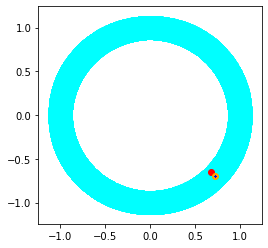

In [16]:
plt.figure(figsize=(4, 4))
# plt.scatter(off_mfld_pts[:, 0], off_mfld_pts[:, 1], s=0.01, alpha=0.5)
plt.scatter(points_n[num_neg:, 0], points_n[num_neg:, 1], s=0.01, alpha=0.5)
idx = 5
# plt.scatter(off_mfld_pts[:, 0], off_mfld_pts[:, 1], color="cyan")

plt.scatter(off_mfld_pts[idx, 0], off_mfld_pts[idx, 1], color="red")
plt.scatter(points_n[num_neg:][idx, 0], points_n[num_neg:][idx, 1], color="orange")

plt.scatter(points_n[num_neg:][indices[idx], 0], points_n[num_neg:][indices[idx], 1], s=0.1, c="blue")
# colors = ["orange", "green"]
# labels = np.round(pca.explained_variance_ratio_, 3)
# arrows = list()
# for i in range(pca.components_.shape[0]):
#     arr = plt.arrow(points_n[idx, 0], points_n[idx, 1], pca.components_[i, 0], pca.components_[i, 1], label=str(labels[i]), color=colors[i])
#     arrows.append(arr)
# plt.legend(arrows, [str(i) for i in labels])

In [ ]:
plt.figure(figsize=(4, 4))


In [19]:
np.dot(off_mfld_pt - on_mfld_pt, nbhr_local_coords[2])

-1.1622371549394984e-06

In [9]:
rdm_idx = np.random.choice(np.arange(num_neg), 10000, replace=False)
min_true_dists = np.zeros(rdm_idx.shape[0])
dev_frm_on_mfld = np.zeros(rdm_idx.shape[0])
for idx in tqdm(range(rdm_idx.shape[0])):
    true_off_mfld_dists = np.linalg.norm(off_mfld_pts[rdm_idx[idx]] - points_n[num_neg:,:], ord=2, axis=1)
    min_true_dist = np.min(true_off_mfld_dists)
    min_true_dists[idx] = min_true_dist
    min_true_dist_idx = np.argmin(true_off_mfld_dists)
    dev_frm_on_mfld[idx] = np.linalg.norm(points_n[num_neg:][min_true_dist_idx] - new_poca[rdm_idx[idx]])
    
    

In [10]:
rdm_idx

array([357232,  68514, 271061, ...,  46014, 228793,  74101])

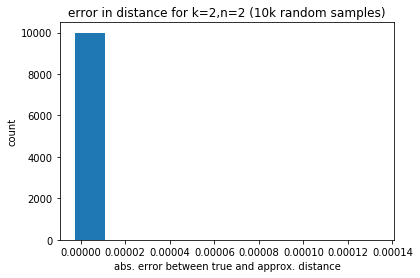

In [11]:
plt.hist(min_true_dists - off_mfld_dists[rdm_idx])
plt.xlabel("abs. error between true and approx. distance")
plt.ylabel("count")
plt.title("error in distance for k={},n={} (10k random samples)".format(k, n))
plt.show()

In [13]:
max(min_true_dists - off_mfld_dists[rdm_idx])

0.00013402127795230978

(array([1.5008e+05, 5.1246e+04, 5.1411e+04, 4.9785e+04, 4.8244e+04,
        3.3959e+04, 1.2540e+04, 2.4400e+03, 2.7700e+02, 1.8000e+01]),
 array([0.        , 0.00025872, 0.00051743, 0.00077615, 0.00103487,
        0.00129359, 0.0015523 , 0.00181102, 0.00206974, 0.00232845,
        0.00258717]),
 <a list of 10 Patch objects>)

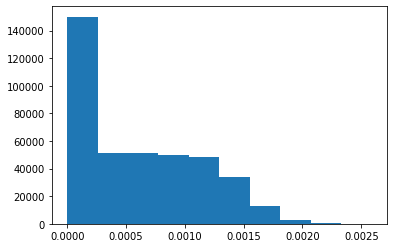

In [22]:
plt.hist(new_poca_prturb_sizes)

In [17]:
np.where(np.abs(min_true_dists - off_mfld_dists[rdm_idx]) > 5e-6)

(array([1147, 1478, 2172, 3001, 3246, 4166, 4503, 5556, 6701, 8643, 8798,
        9352]),)

(400000,)

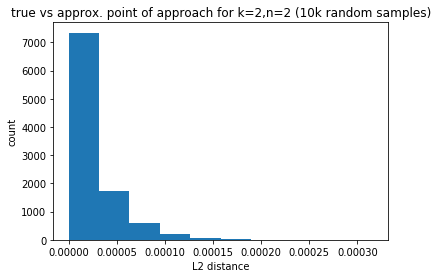

In [23]:
plt.hist(dev_frm_on_mfld)
plt.xlabel("L2 distance")
plt.ylabel("count")
plt.title("true vs approx. point of approach for k={},n={} (10k random samples)".format(k, n))
plt.show()

In [26]:
max(dev_frm_on_mfld)

0.00031602736883790507

In [22]:
np.argmin(np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1)), \
np.min(np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1))

(183969, 0.03786256990766121)

In [23]:
np.linalg.norm(off_mfld_pts[0] - points_n[:N//2,:], ord=2, axis=1)

array([0.04658179, 1.71577159, 1.38675184, ..., 1.44299178, 1.79183774,
       0.5097944 ])

In [24]:
np.linalg.norm(points_n[141727] - points_n[0])

0.04689816673859133

In [25]:
off_mfld_dists[0]

0.04658178909987768

In [49]:
tmp = np.random.normal(0, 1, size=(50, 500))
tmp_pca = PCA()
tmp_pca.fit(tmp)


array([[ 0.02824323,  0.00235902,  0.01950889, ..., -0.03805938,
        -0.01381973, -0.00307733],
       [ 0.00770392, -0.07358862, -0.048848  , ..., -0.02004137,
         0.00309767,  0.07561612],
       [ 0.03270278,  0.06981782, -0.07356335, ...,  0.00973231,
        -0.02722055,  0.02475773],
       ...,
       [ 0.08825714, -0.0063782 ,  0.04923243, ..., -0.05390884,
         0.00651722,  0.07160276],
       [-0.00234416,  0.00937723,  0.0077863 , ..., -0.04157526,
        -0.01050973,  0.02776842],
       [-0.24057345,  0.06831079, -0.11079424, ...,  0.0103417 ,
        -0.02203047,  0.01865837]])

In [50]:
tmp_pca.components_.shape

(50, 500)

In [51]:
tmp_pca.explained_variance_ratio_

array([3.29956181e-02, 3.25079828e-02, 3.22565262e-02, 3.11799404e-02,
       3.06632475e-02, 3.01812442e-02, 2.88631601e-02, 2.86225564e-02,
       2.82011201e-02, 2.76663391e-02, 2.64148828e-02, 2.56271934e-02,
       2.49715904e-02, 2.47920407e-02, 2.41121771e-02, 2.37524494e-02,
       2.32314183e-02, 2.24774617e-02, 2.22923907e-02, 2.18679557e-02,
       2.12356529e-02, 2.08215778e-02, 2.02357207e-02, 1.99912026e-02,
       1.97705482e-02, 1.93732695e-02, 1.90554016e-02, 1.85600662e-02,
       1.84403614e-02, 1.76812580e-02, 1.73093909e-02, 1.67078570e-02,
       1.61468635e-02, 1.59964393e-02, 1.58146529e-02, 1.52381204e-02,
       1.49448302e-02, 1.45239901e-02, 1.41972889e-02, 1.35859178e-02,
       1.34444766e-02, 1.30615833e-02, 1.26759973e-02, 1.23808206e-02,
       1.22690058e-02, 1.18452026e-02, 1.14014961e-02, 1.09030661e-02,
       9.71064657e-03, 6.50614319e-33])